# <center>Movie Analysis:  Assessing Domestic Profits by Genre, Director, Writer, and Release Date</center>
## <center>Norman Jen and David Johnson</center>

<center><img src = "Images/movie_theater.jpg"></center>

### **Overview**

This project uses data sets from __[IMDb](https://www.imdb.com/)__ and __[The Numbers](https://www.the-numbers.com/)__, two of the largest internet databases for film.  Our goal is to analyze this data and assess worldwide, domestic, and foreign profits gained by specific genres, directors, writers, and release dates.  Descriptive analysis has shown clear correlation between certain genres and other categories and a film's overall success.  Our company can use this data to determine which type of film is most worth investing in to maximize domestic profit.

### **The Business Need**

Our company has seen the success of companies such as __[Netflix](https://www.netflix.com/)__ and __[Amazon](https://www.amazon.com/Amazon-Video/b?ie=UTF8&node=2858778011)__ making original cinema content and would like to begin investing into a movie studio of its own.  Our Company's business is currently centered around film production, so they are using data analysis to determine its studio's first film ventures.  This will allow our company to safely invest in a film that is most likely to result in high domestic profits.

#### **Data**

Data for this project was provided by __[IMDb](https://www.imdb.com/)__ and __[The Numbers](https://www.the-numbers.com/)__.  Between these two databases, we were able to get data on movie genres, average user ratings, release date, budget, gross sales, and much more.  We used this information to focus on sorting movies into categories that can show direct correlation with domestic profit.

In [1]:
import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
%matplotlib inline

In [2]:
cast = sqlite3.connect('zippedData/im.db')
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#### **SQL Queries**

IMDb's database provided an enormous amount of information.  In order to isolate the relevant information, we used SQL queries to extract the correct data and transform them into pandas dataframes for analysis later on.  In our review query, we specified only movies in the 'US' region.  We did not need to do the same for other queries since we would be joining using an inner merge.

In [3]:
review_query = """
    SELECT movie_basics.primary_title AS title, movie_basics.genres AS genres, 
    movie_ratings.averagerating AS average_rating, movie_ratings.numvotes AS num_votes, movie_akas.region AS region
    FROM movie_basics
    JOIN movie_ratings
        ON movie_basics.movie_id = movie_ratings.movie_id
    JOIN movie_akas
        ON movie_basics.movie_id = movie_akas.movie_id
    WHERE region = 'US'
    ORDER BY movie_ratings.averagerating DESC
"""
df_reviews = pd.read_sql(review_query, cast)

In [4]:
writer_query = """
    SELECT movie_basics.primary_title AS title, persons.primary_name AS writer
    FROM principals
    JOIN movie_basics
        ON principals.movie_id = movie_basics.movie_id
    JOIN persons
        ON principals.person_id = persons.person_id
    WHERE principals.category = 'writer'
"""
df_writer = pd.read_sql(writer_query, cast)

In [5]:
director_query = """
    SELECT movie_basics.primary_title AS title, persons.primary_name AS director
    FROM principals
    JOIN movie_basics
        ON principals.movie_id = movie_basics.movie_id
    JOIN persons
        ON principals.person_id = persons.person_id
    WHERE principals.category = 'director'
"""
df_director = pd.read_sql(director_query, cast)

cast.close()

#### **Data Cleaning**

Overall, our data was mostly complete.  Instead of dealing with missing data, we focused on tweaking the movie titles in each database to most closely resemble each other.  We removed all special characters and spaces, made all letters lower case, and made sure all titles that were purely numeric such as "13" and "2010" were classified as strings.

In [6]:
spec_char = r'[^\w\s]'
df_reviews['title'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_reviews['title'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_reviews['title'] = df_reviews['title'].str.lower()
df_reviews['genres'] = df_reviews['genres'].fillna('Unknown')
df_reviews.drop_duplicates(subset = 'title', keep = 'first', inplace = True)

df_writer_director = pd.merge(df_writer, df_director, how = 'inner', left_on = 'title', right_on = 'title')
df_writer_director['title'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_writer_director['title'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_writer_director['title'] = df_writer_director['title'].str.lower()

df_budget['movie'] = df_budget['movie'].astype(str)
df_budget['movie'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_budget['movie'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_budget['movie'] = df_budget['movie'].str.lower()
df_budget['production_budget'] = df_budget['production_budget'].str.replace(',', '')
df_budget['production_budget'] = df_budget['production_budget'].str.replace('$', '')
df_budget['production_budget'] = df_budget['production_budget'].astype(np.int64)
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace(',', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace('$', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].astype(np.int64)
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace(',', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace('$', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].astype(np.int64)
df_budget['release_date']= pd.to_datetime(df_budget['release_date'])

In [7]:
df_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


In [8]:
df_writer_director.head()

,title,writer,director
0,asleepinthesun,Adolfo Bioy Casares,Alejandro Chomski
1,smokingnonsmoking,Gary O. Bennett,Alyssa R. Bennett
2,extremelyloudincrediblyclose,Eric Roth,Stephen Daldry
3,extremelyloudincrediblyclose,Jonathan Safran Foer,Stephen Daldry
4,kidcannabis,Mark Binelli,John Stockwell


In [9]:
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,avatar,425000000,760507625,2776345279
1,2,2011-05-20,piratesofthecaribbeanonstrangertides,410600000,241063875,1045663875
2,3,2019-06-07,darkphoenix,350000000,42762350,149762350
3,4,2015-05-01,avengersageofultron,330600000,459005868,1403013963
4,5,2017-12-15,starwarsepviiithelastjedi,317000000,620181382,1316721747


#### **Data Analysis - Profits**

From our databases, we got information on production budget, domestic gross, and worlwide gross.  With that, we can calculate domestic, foreign, and worldwide profits and add this information to our comprehensive database

In [10]:
df_budget['worldwide_profit'] = df_budget['worldwide_gross'] - df_budget['production_budget']
df_budget['domestic_profit'] = df_budget['domestic_gross'] - df_budget['production_budget']
df_budget.sort_values(by = ['domestic_profit'], ascending = False, inplace = True)
df_budget['foreign_profit'] = df_budget['worldwide_profit'] - df_budget['domestic_profit']
df_budget['foreign_profit'] = df_budget['foreign_profit'].astype(np.int64)
df_budget.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,foreign_profit
count,5782.00,5782.00,5782.00,5782.00,5782.00,5782.00,5782.00
mean,50.37,31587757.10,41873326.87,91487460.91,59899703.81,10285569.77,49614134.04
std,28.82,41812076.83,68240597.36,174719968.78,146088881.08,49921366.46,113119236.57
min,1.00,1100.00,0.00,0.00,-200237650.00,-307237650.00,0.00
25%,25.00,5000000.00,1429534.50,4125414.75,-2189070.75,-9132757.00,0.00
50%,50.00,17000000.00,17225945.00,27984448.50,8550285.50,-348775.50,5701765.50
75%,75.00,40000000.00,52348661.50,97645836.50,60968501.75,17781444.00,46821100.75
max,100.00,425000000.00,936662225.00,2776345279.00,2351345279.00,630662225.00,2015837654.00


#### **Creating a Comprehensive Database**

Our next step was to combine all the information we had together into one cleaned, comprehensive, and informative dataframe.  

In [11]:
result = pd.merge(df_budget, df_reviews, how='inner', left_on='movie', right_on='title')
common_values = result['movie'].tolist()
movie_titles = list(set(common_values))

In [12]:
worldwide_profit = []
ww = 0
domestic_profit = []
dom = 0
foreign_profit = []
frn = 0
average_rating = []
rat = 0.0
release_date = []
rel = None
movie_genres = []
gen = None
vote_count = []
vote = None

for title in movie_titles:
    ww = df_budget.loc[df_budget['movie'] == title, 'worldwide_profit'].iloc[0]
    worldwide_profit.append(ww)
    dom = df_budget.loc[df_budget['movie'] == title, 'domestic_profit'].iloc[0]
    domestic_profit.append(dom)
    frn = df_budget.loc[df_budget['movie'] == title, 'foreign_profit'].iloc[0]
    foreign_profit.append(frn)
    rat = df_reviews.loc[df_reviews['title'] == title, 'average_rating'].iloc[0]
    average_rating.append(rat)
    rel = df_budget.loc[df_budget['movie'] == title, 'release_date'].iloc[0].date()
    release_date.append(rel)
    gen = df_reviews.loc[df_reviews['title'] == title, 'genres'].iloc[0]
    movie_genres.append(gen)
    vote = df_reviews.loc[df_reviews['title'] == title, 'num_votes'].iloc[0]
    vote_count.append(vote)

d = {'title': movie_titles, 'release_date': release_date, 'movie_genres': movie_genres, 'worldwide_profit': worldwide_profit, 'domestic_profit': domestic_profit, 'foreign_profit': foreign_profit, 'average_rating': average_rating, 'num_votes': vote_count}
df = pd.DataFrame(data = d)

df['movie_genres'] = df['movie_genres'].map(lambda x: x.split(','))
df['release_date'] = pd.to_datetime(df['release_date'])
df_writer_director = df_writer_director.groupby('title').agg({'writer': lambda x: list(set(x)), 'director': lambda x: list(set(x))}).reset_index()
df = pd.merge(df, df_writer_director, how = 'left')
df.dropna(subset=['writer'], inplace = True)
df.reset_index(drop = True, inplace = True)

In [13]:
df.head()

,title,release_date,movie_genres,worldwide_profit,domestic_profit,foreign_profit,average_rating,num_votes,writer,director
0,seventhson,2015-02-06,"[Action, Adventure, Fantasy]",13874967,-77274215,91149182,5.5,66565,"[Matt Greenberg, Joseph Delaney, Steven Knight...",[Sergei Bodrov]
1,magicmikexxl,2015-07-01,"[Comedy, Drama, Music]",109160597,51513057,57647540,5.6,48497,[Reid Carolin],[Gregory Jacobs]
2,thehousewithaclockinitswalls,2018-09-21,"[Comedy, Fantasy, Horror]",86331750,28549695,57782055,6.0,32995,"[Eric Kripke, John Bellairs]",[Eli Roth]
3,annabelle,2014-10-03,"[Horror, Mystery, Thriller]",250362920,77773813,172589107,5.4,122039,[Gary Dauberman],[John R. Leonetti]
4,hostage,2005-03-11,[Thriller],2636443,-40363557,43000000,5.7,446,"[Marian Urban, Peter Pistanek]","[Juraj Nvota, Tony Glazer]"


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             1377 non-null   object        
 1   release_date      1377 non-null   datetime64[ns]
 2   movie_genres      1377 non-null   object        
 3   worldwide_profit  1377 non-null   int64         
 4   domestic_profit   1377 non-null   int64         
 5   foreign_profit    1377 non-null   int64         
 6   average_rating    1377 non-null   float64       
 7   num_votes         1377 non-null   int64         
 8   writer            1377 non-null   object        
 9   director          1377 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 107.7+ KB


#### **Sorting by Genre**

The first category we looked at was genre.  This one was tricky, as most movies have multiple genres and we wanted to make sure that they were all represented in our conclusions.  We first created a list of the genres present in our database and took a preliminary look at the popularity of each genre.

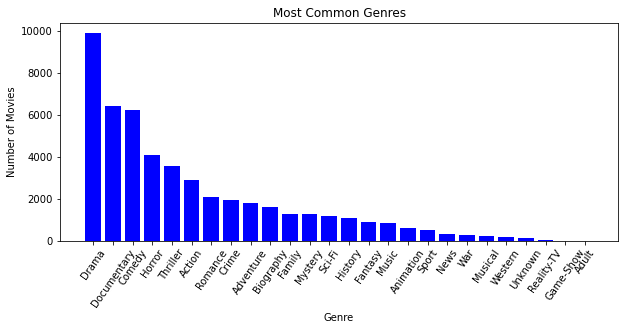

In [15]:
genres = pd.Series(df_reviews.genres.values, index = df_reviews.title).to_dict()
delimiter = ','
for key, value in genres.items():
    genres[key] = value.split(delimiter)

list_of_genres = []
for key, value in genres.items():
    for index in value:
        if index not in list_of_genres:
            list_of_genres.append(index)

genre_count = {}
for genre in list_of_genres:
    genre_count[genre] = 0
for key, value in genres.items():
    for index in value:
        genre_count[index] += 1

sorted_genre_count = dict(sorted(genre_count.items(), key=lambda x:x[1], reverse = True))

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title('Most Common Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Movies')
plt.xticks(rotation=55)
plt.bar(sorted_genre_count.keys(), sorted_genre_count.values(), color='b');

#### **Determining Profits by Genre**

From here, we wanted to determine what the average profit a movie from a certain genre might expect to generate.  To do this, we totaled the profits (gross - budget) of each movie a given genre and divided it by the number of movies described as that genre.

We also needed to create a grouped dataframe that showed the mean profits, rating, and number of votes to better intepret the rating of the film's genre.

In [16]:
df_genre_exploded = df.explode('movie_genres')
df_genre_exploded.replace(to_replace = 'Music', value = 'Musical', inplace = True)
df_genre = df_genre_exploded.groupby('movie_genres').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_genre.drop('Unknown', axis = 'rows', inplace = True)
df_genre.reset_index(inplace = True)

df_genre['worldwide_profit'] = df_genre['worldwide_profit'].astype(float)
df_genre['domestic_profit'] = df_genre['domestic_profit'].astype(float)
df_genre['foreign_profit'] = df_genre['foreign_profit'].astype(float)
df_genre['average_rating'] = df_genre['average_rating'].astype(float)
df_genre['num_votes'] = df_genre['num_votes'].astype(float)

pd.options.display.float_format = '{:.2f}'.format
df_genre.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_genre.reset_index(drop = True, inplace = True)
df_genre

,movie_genres,worldwide_profit,domestic_profit,foreign_profit,average_rating,num_votes
0,Animation,256805131.83,31685555.52,225119576.31,6.43,117466.35
1,Sci-Fi,250450655.58,30232527.92,220218127.66,6.42,249103.88
2,Musical,70915576.74,24322560.51,46593016.23,6.47,48849.33
3,Adventure,252530420.93,21328546.66,231201874.27,6.47,198104.45
4,Comedy,99097730.28,19359403.67,79738326.61,6.19,93399.31
5,Biography,60487756.70,15342088.66,45145668.03,7.07,114272.39
6,Family,121287565.81,14494736.16,106792829.65,6.17,73148.62
7,Horror,48341373.74,13523988.51,34817385.22,5.52,60441.31
8,Romance,51240595.64,12875523.10,38365072.53,6.27,80761.51
9,Mystery,59415718.62,12491822.06,46923896.56,6.12,115462.31


#### **Determining Profits by Season**

Now that we've determined that movies in the Musical and Animation genres have the highest domestic profits on average, we examined the release dates.  Since musicals and animation movies are largely marketed towards children, the season a film is released in is likely to have an impact on its success.

In [17]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['season'] = df['release_date'].dt.month.apply(get_season)
df_season = df.groupby('season').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_season['worldwide_profit'] = df_season['worldwide_profit'].astype(float)
df_season['domestic_profit'] = df_season['domestic_profit'].astype(float)
df_season['foreign_profit'] = df_season['foreign_profit'].astype(float)
df_season['average_rating'] = df_season['average_rating'].astype(float)
df_season['num_votes'] = df_season['num_votes'].astype(float)
df_season.sort_values('domestic_profit', ascending = False, inplace = True)
df_season.reset_index(inplace = True)
df_season

,season,worldwide_profit,domestic_profit,foreign_profit,average_rating,num_votes
0,Summer,127182724.69,18768286.78,108414437.91,6.29,120099.48
1,Spring,114465193.89,12576463.40,101888730.49,6.30,114888.83
2,Winter,74132606.67,10378528.62,63754078.05,6.16,88313.28
3,Fall,86986750.38,10057378.78,76929371.60,6.49,113826.70


#### **Determining Profits by Director and Writer**

Lastly, we wanted to recommend the writers and directors that produced movies with the highest domestic profit.  First, we narrowed our data down to only movies in the Music and/or Animation genres.  Since we are recommending these genres, it made sense to recommend writers and directors who saw the most success in those areas.

By examining the top 10 films in those genres by domestic profit, we noticed a few writers and directors that appeared multiple times and have chosen them as our recommendation.

In [18]:
mask = df['movie_genres'].apply(lambda x: 'Music' in x or 'Animation' in x)
df_musical_animation = df.loc[mask].copy()
df_musical_animation.sort_values(by='domestic_profit', ascending=False, inplace=True)
df_musical_animation = df_musical_animation.head(10)
df_musical_animation.reset_index(drop = True, inplace = True)
df_musical_animation

,title,release_date,movie_genres,worldwide_profit,domestic_profit,foreign_profit,average_rating,num_votes,writer,director,season
0,thesecretlifeofpets,2016-07-08,"[Adventure, Animation, Comedy]",811750534,293384330,518366204,6.50,161997,"[Cinco Paul, Brian Lynch, Ken Daurio]","[Yarrow Cheney, Chris Renaud]",Summer
1,despicableme2,2013-07-03,"[Adventure, Animation, Comedy]",899216835,292065385,607151450,7.40,344230,"[Cinco Paul, Ken Daurio]","[Pierre Coffin, Chris Renaud]",Summer
2,findingdory,2016-06-17,"[Adventure, Animation, Comedy]",821215193,286295561,534919632,7.30,213542,"[Victoria Strouse, Bob Peterson]","[Andrew Stanton, Angus MacLane]",Summer
3,minions,2015-07-10,"[Adventure, Animation, Comedy]",1086336173,262045770,824290403,6.40,193917,[Brian Lynch],[Kyle Balda],Summer
4,frozen,2013-11-22,"[Adventure, Animation, Comedy]",1122469910,250738009,871731901,7.50,516998,"[Hans Christian Andersen, Ka Yee Yim, Shane Mo...","[Chi-kin Kwok, Adam Green, Jennifer Lee, Chris...",Fall
5,toystory3,2010-06-18,"[Adventure, Animation, Comedy]",868879522,215004880,653874642,8.30,682218,"[Andrew Stanton, John Lasseter, Michael Arndt]",[Lee Unkrich],Summer
6,thelegomovie,2014-02-07,"[Action, Adventure, Animation]",397729388,197784718,199944670,7.80,304179,"[Godtfred Kirk Christiansen, Kevin Hageman, Da...","[Christopher Miller, Phil Lord]",Winter
7,zootopia,2016-03-04,"[Adventure, Animation, Comedy]",869429616,191268248,678161368,8.00,383446,"[Josie Trinidad, Phil Johnston, Jim Reardon]","[Rich Moore, Jared Bush, Byron Howard]",Spring
8,despicableme3,2017-06-30,"[Adventure, Animation, Comedy]",959727750,189624300,770103450,6.30,92580,"[Cinco Paul, Ken Daurio]","[Pierre Coffin, Kyle Balda, Eric Guillon]",Summer
9,despicableme,2010-07-09,"[Animation, Comedy, Family]",474464573,182513985,291950588,7.70,464511,"[Cinco Paul, Sergio Pablos, Ken Daurio]","[Pierre Coffin, Chris Renaud]",Summer


In [19]:
df_writer_exploded = df_musical_animation.explode('writer')

df_writer = df_writer_exploded.groupby('writer').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_writer.reset_index(inplace = True)

df_writer['worldwide_profit'] = df_writer['worldwide_profit'].astype(float)
df_writer['domestic_profit'] = df_writer['domestic_profit'].astype(float)
df_writer['foreign_profit'] = df_writer['foreign_profit'].astype(float)
df_writer['average_rating'] = df_writer['average_rating'].astype(float)
df_writer['num_votes'] = df_writer['num_votes'].astype(float)
df_writer.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_writer.reset_index(drop = True, inplace = True)
df_writer_exploded['writer'].value_counts().head()

Cinco Paul               4
Ken Daurio               4
Brian Lynch              2
Ole Kirk Christiansen    1
Ka Yee Yim               1
Name: writer, dtype: int64

In [20]:
df_director_exploded = df_musical_animation.explode('director')

df_director = df_director_exploded.groupby('director').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_director.reset_index(inplace = True)

df_director['worldwide_profit'] = df_director['worldwide_profit'].astype(float)
df_director['domestic_profit'] = df_director['domestic_profit'].astype(float)
df_director['foreign_profit'] = df_director['foreign_profit'].astype(float)
df_director['average_rating'] = df_director['average_rating'].astype(float)
df_director['num_votes'] = df_director['num_votes'].astype(float)
df_director.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_director.reset_index(drop = True, inplace = True)
df_director_exploded['director'].value_counts().head()

Pierre Coffin     3
Chris Renaud      3
Kyle Balda        2
Lee Unkrich       1
Andrew Stanton    1
Name: director, dtype: int64

#### **Conclusions**

Now that we had drawn the correct information from our initial raw data sets and performed the relevant analysis and formatting, we were ready to begin displaying our results.

#### **Genre - Musical/Animation**

Our analysis shows that musicals and animated films tend to produce the highest domestic profits by average.  We aldo provided information on foreign and worldwide profits to compare how genres perform in other markets.

In [21]:
df_for = df_genre.sort_values(by = 'foreign_profit', ascending = False)
df_ww = df_genre.sort_values(by = 'worldwide_profit', ascending = False)

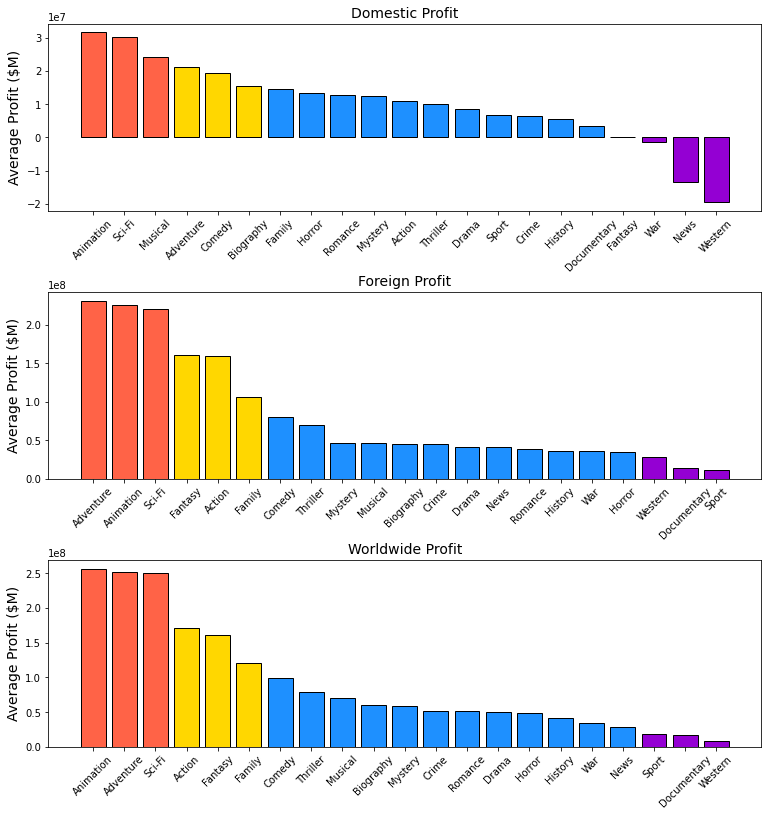

In [22]:
fig, axs = plt.subplots(3, figsize = (12, 12))
fig.tight_layout(pad = 6.0)
genre_colors = ['tomato', 'tomato', 'tomato', 'gold', 'gold', 'gold', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue',
               'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet']
axs[0].bar('movie_genres', 'domestic_profit', data = df_genre, color = genre_colors, edgecolor = 'black')
axs[1].bar('movie_genres', 'foreign_profit', data = df_for, color = genre_colors, edgecolor = 'black')
axs[2].bar('movie_genres', 'worldwide_profit', data = df_ww, color = genre_colors, edgecolor = 'black')
axs[0].set_title('Domestic Profit', fontsize = 14)
axs[0].set_ylabel('Average Profit ($M)', fontsize = 14)
axs[1].set_title('Foreign Profit', fontsize = 14)
axs[1].set_ylabel('Average Profit ($M)', fontsize = 14)
axs[2].set_title('Worldwide Profit', fontsize = 14)
axs[2].set_ylabel('Average Profit ($M)', fontsize = 14)
axs[0].tick_params(axis = 'x', labelrotation = 45)
axs[1].tick_params(axis = 'x', labelrotation = 45)
axs[2].tick_params(axis = 'x', labelrotation = 45)
plt.savefig("./Images/genre_profits.jpg", dpi=150, facecolor='white')
plt.show()

#### **Season - Summer**

By sorting release dates into seasons, we see that domestic profits for films are at their highest when the films are released in the summer.  This coincides with our recommendation for genre, since musicals and animated movies are generally marketed towards children.

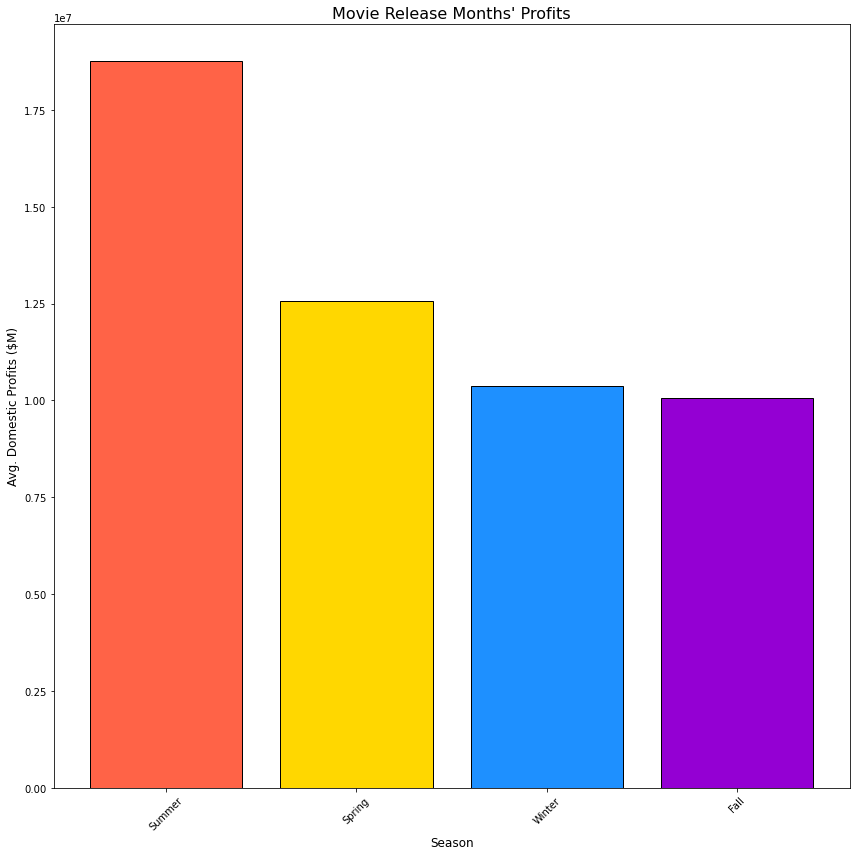

In [23]:
fig, ax = plt.subplots(figsize = (12, 12))
fig.tight_layout()
season_colors = ['tomato', 'gold', 'dodgerblue', 'darkviolet']
ax.bar(x = 'season', height = 'domestic_profit', data = df_season, color = season_colors, edgecolor = 'black')
ax.set_title("Movie Release Months' Profits", fontsize = 16)

ax.set_xlabel('Season', fontsize = 12)
ax.set_ylabel('Avg. Domestic Profits ($M)', fontsize = 12)
plt.xticks(rotation=45);
plt.tight_layout()
plt.savefig("./Images/season_profits.jpg", dpi=150, facecolor='white')
plt.show()

#### **Writer - Cinco Paul or Ken Daurio**

We found that amongst the top 10 Musical/Animation films by domestic profits, Cinco Paul and Ken Daurio each directed 3 movies.  Because they have written for 3 of the top 10 profiting movies in the genre, we feel confident recommending them as writers for our film.

Cinco Paul and Ken Daurio were both writers for The Secret Life of Pets,  Despicable Me, Despicable Me 2, and Despicable Me 3 and generated $957,588,000.00 in domestic profit.

#### **Director - Chris Renaud or Pierre Coffin**

Chris Renaud, and Pierre Coffin each directed 3 out of the top 10 Music/Animation films by domestic profit.  They directed the following:

Chris Renaud -  The Secret Life of Pets, Despicable Me, and Despicable Me 2 - \\$767,963,700.00 in domestic profit

Pierre Coffin - Despicable Me, Despicable Me 2 and Despicable Me 3 - \\$664,203,670.00 in domestic profit


In [24]:
df_director_profit = df_director_exploded.groupby(by = 'director').sum()
df_director_profit.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_director_profit.reset_index(inplace = True)
df_writer_profit = df_writer_exploded.groupby(by = 'writer').sum()
df_writer_profit.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_writer_profit.reset_index(inplace = True)
df_writer_profit['writer'].replace(to_replace = 'Gabrielle-Suzanne Barbot de Villeneuve', value = 'Gabrielle Barbot', inplace = True)
df_writer_profit['writer'].replace(to_replace = 'Jeanne-Marie Leprince de Beaumont', value = 'Jeanne-Marie Leprince', inplace = True)

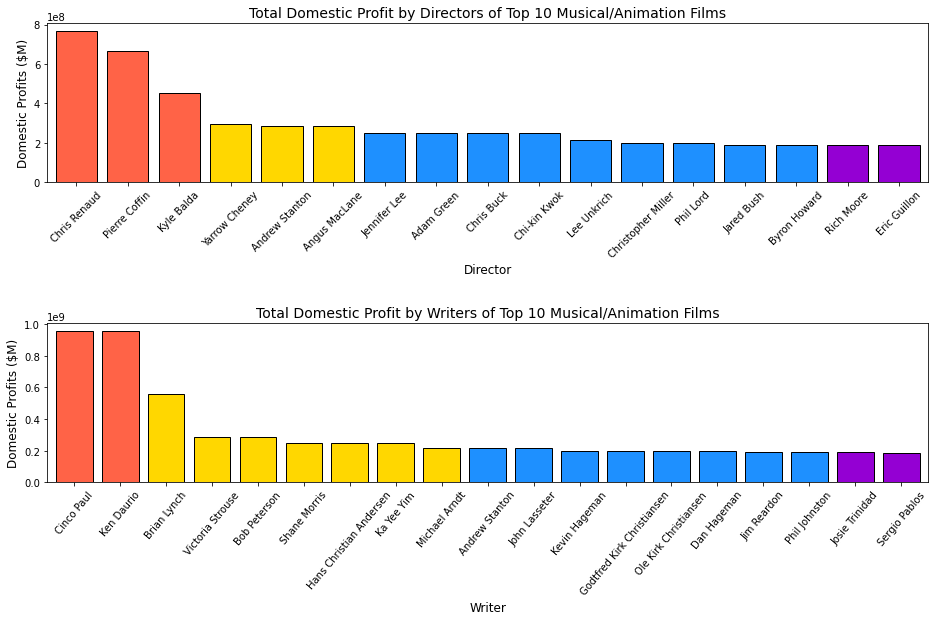

In [25]:
fig, axs = plt.subplots(2, figsize = (16, 10))
fig.tight_layout(pad = 12.0)
dir_colors = ['tomato', 'tomato', 'tomato', 'gold', 'gold', 'gold', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue',
               'dodgerblue', 'dodgerblue', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet']
wrt_colors = ['tomato', 'tomato', 'gold', 'gold', 'gold', 'gold', 'gold', 'gold', 'gold', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue',
               'dodgerblue', 'dodgerblue', 'dodgerblue', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet', 'darkviolet',]
axs[0].bar(x = 'director', height = 'domestic_profit', data = df_director_profit, color = dir_colors, edgecolor = 'black')
axs[0].set_title('Total Domestic Profit by Directors of Top 10 Musical/Animation Films', fontsize = 14)

axs[0].set_xlabel('Director', fontsize = 12)
axs[0].set_ylabel('Domestic Profits ($M)', fontsize = 12)
axs[0].tick_params(axis = 'x', labelrotation = 45)
axs[0].margins(x = 0.01)

axs[1].bar(x = 'writer', height = 'domestic_profit', data = df_writer_profit, color = wrt_colors, edgecolor = 'black')
axs[1].set_title('Total Domestic Profit by Writers of Top 10 Musical/Animation Films', fontsize = 14)

axs[1].set_xlabel('Writer', fontsize = 12)
axs[1].set_ylabel('Domestic Profits ($M)', fontsize = 12)
axs[1].tick_params(axis = 'x', labelrotation = 50)
axs[1].margins(x = 0.01);
plt.savefig("./Images/writer_director_profits.jpg", dpi=150, facecolor='white')
plt.show()

## Conclusion

This analysis leads to four recommendations for starting our movie production business:

- **Focus on musical and animation films.** The analysis indicates that producing animation musicals, inspired by hits like Frozen and Moana, presents a lucrative opportunity for success in the movie industry, with animation leading in both domestic and worldwide profits.
- **Release our movies during the summer time.** The analysis indicates that summer releases, coinciding with school vacations, garnered the highest average domestic profit, with Animation and Musical genres, appealing to younger audiences, particularly benefiting from this trend.
- **Choose writers with a proven track record.** Cinco Paul and Ken Daurio, having contributed as writers to three highly successful films within the top 10 Musical/Animation movies by domestic profits, including "The Secret Life of Pets," "Despicable Me 2," and "Despicable Me 3," are confidently recommended as writers for our film.
- **Choose directors with a proven track record.** Chris Renaud and Pierre Coffin each directed two of the top 10 Musical/Animation films by domestic profit, showcasing their expertise in directing successful films in the genre, with notable works including "Minions," "The Secret Life of Pets," and the "Despicable Me" franchise.

### Next Steps

Further analyses could yield additional insights to how we can further improve our movie production business:

- **Find the best voice actors/singers.** To find the best voice actors/singers, we could potentially conduct focus group testing to gather feedback and insights on their performances, helping us identify the most suitable candidates for our project.
- **Budget planning.** Develop a comprehensive budget plan outlining expenses for pre-production, production, and post-production stages.
- **Marketing strategy.** Develop a marketing plan to promote the film and generate buzz leading up to its release.
